# **Feed Forward Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0001
- Layers: [256, 128, 64]
- Dropout: 0.3


In [160]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [289]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/NotAnnotated/Regular/AveragePooled/split_features_1s_all_1D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [290]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/FFNN/'

In [291]:
train_data = data['train'].copy()
val_data = data['val'].copy()

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [292]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [293]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [294]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **Feed Forward Model**

In [295]:
def build_model(input_features,
                hidden_layers=[256, 128, 64],
                learning_rate=0.0001,
                output_units=20,
                dropout_rate=0.3):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [296]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_1s_model_training_history_1D.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [297]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [298]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [299]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['cqt'], train_features['melspectrogram']), axis=1)
training_features.shape

(42578, 244)

In [300]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['cqt'], val_features['melspectrogram']), axis=1)
validation_features.shape

(13083, 244)

In [301]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2144 - loss: 2.5819 - val_accuracy: 0.2505 - val_loss: 2.4917
Epoch 2/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4215 - loss: 1.9210 - val_accuracy: 0.3066 - val_loss: 2.4104
Epoch 3/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5016 - loss: 1.6658 - val_accuracy: 0.3212 - val_loss: 2.3861
Epoch 4/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5531 - loss: 1.5089 - val_accuracy: 0.3311 - val_loss: 2.4583
Epoch 5/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5890 - loss: 1.3894 - val_accuracy: 0.3434 - val_loss: 2.3768
Epoch 6/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6229 - loss: 1.2715 - val_accuracy: 0.3365 - val_loss: 2.4651
Epoch 7/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6445 - loss: 1.1895 - val_accuracy: 0.3482 - val_loss: 2.5133
Epoch 8/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6684 - loss: 1

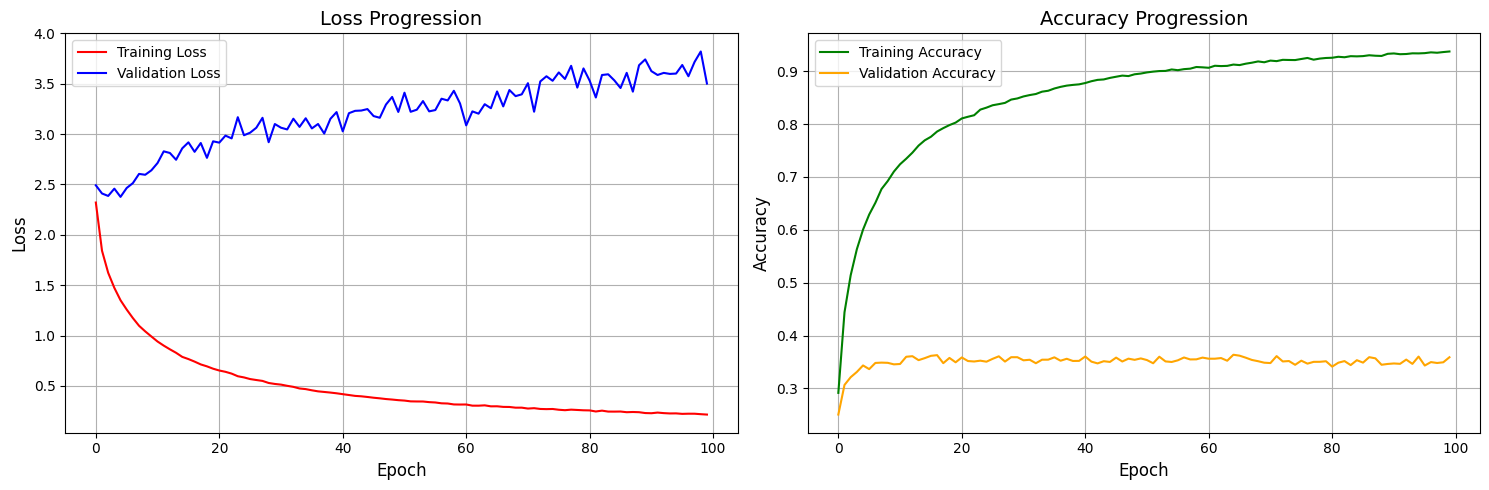

In [302]:
visualize(history, 'all_features')

In [303]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - accuracy: 0.9869 - loss: 0.0545
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3601 - loss: 3.5186


In [304]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.36      0.46      0.40       793
           1       0.32      0.56      0.41      1294
           2       0.26      0.32      0.29       617
           3       0.60      0.63      0.62       984
           4       0.13      0.15      0.14       229
           5       0.14      0.07      0.10       303
           6       0.21      0.28      0.24       275
           7       0.57      0.47      0.52       698
           8       0.18      0.55      0.27       176
           9       0.30      0.41      0.35       227
          10       0.28      0.22      0.25       455
          11       0.36      0.03      0.06      1660
          12       0.53      0.39      0.45      1261
          13       0.47      0.42      0.44       502
          14       0.17      0.29      0.21       156
          15       0.31      0.37      0.34       798
          16       0.52      0.55      0.54   

### Mel Spectrogram and Chroma

In [305]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma']), axis=1)
training_features.shape

(42578, 140)

In [306]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma']), axis=1)
validation_features.shape

(13083, 140)

In [307]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1930 - loss: 2.6464 - val_accuracy: 0.2828 - val_loss: 2.4478
Epoch 2/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3721 - loss: 2.0398 - val_accuracy: 0.3036 - val_loss: 2.4258
Epoch 3/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4489 - loss: 1.8095 - val_accuracy: 0.3019 - val_loss: 2.4160
Epoch 4/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4932 - loss: 1.6670 - val_accuracy: 0.3232 - val_loss: 2.4112
Epoch 5/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5342 - loss: 1.5446 - val_accuracy: 0.3265 - val_loss: 2.4666
Epoch 6/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5604 - loss: 1.4536 - val_accuracy: 0.3307 - val_loss: 2.4669
Epoch 7/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5878 - loss: 1.3765 - val_accuracy: 0.3298 - val_loss: 2.4762
Epoch 8/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6076 - loss: 1

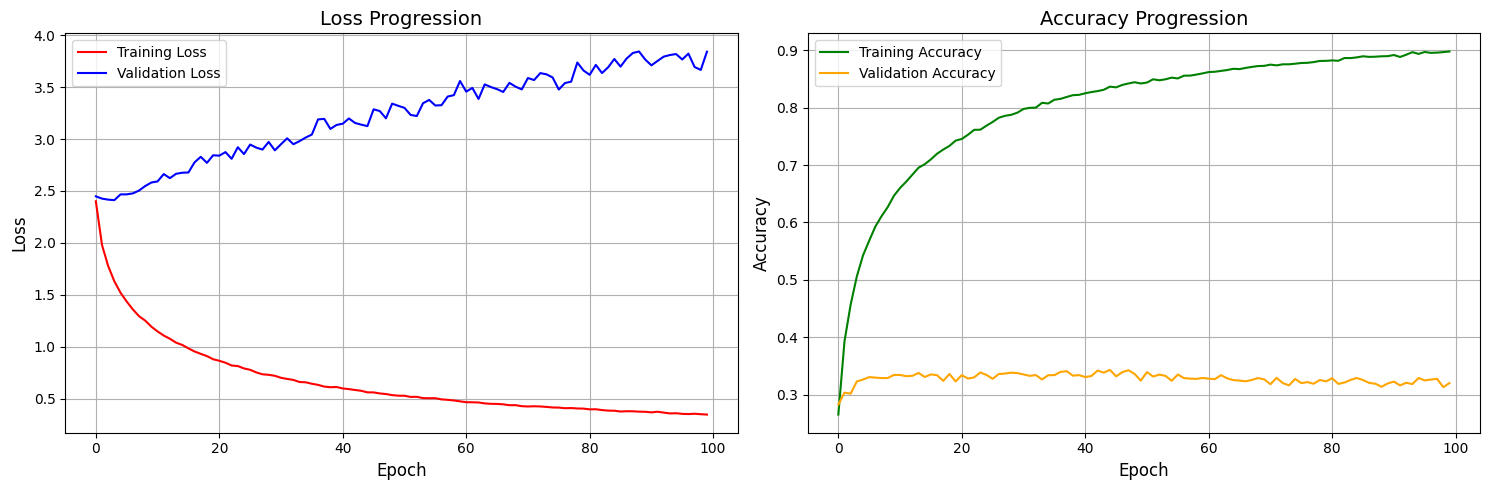

In [308]:
visualize(history, 'melspectrogram_chroma')

In [309]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9695 - loss: 0.1171
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.3205 - loss: 3.8378


In [310]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.30      0.52      0.38       793
           1       0.36      0.58      0.44      1294
           2       0.33      0.38      0.35       617
           3       0.43      0.56      0.48       984
           4       0.13      0.17      0.15       229
           5       0.09      0.08      0.08       303
           6       0.07      0.04      0.05       275
           7       0.51      0.47      0.49       698
           8       0.17      0.52      0.25       176
           9       0.20      0.37      0.26       227
          10       0.23      0.21      0.22       455
          11       0.18      0.02      0.04      1660
          12       0.39      0.26      0.31      1261
          13       0.50      0.51      0.50       502
          14       0.09      0.12      0.10       156
          15       0.30      0.35      0.32       798
          16       0.39      0.35      0.37   

### With Mel Spectrogram, MFCCs and Chroma

In [311]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)
training_features.shape

(42578, 160)

In [312]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)
validation_features.shape

(13083, 160)

In [313]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2059 - loss: 2.6498 - val_accuracy: 0.2879 - val_loss: 2.4371
Epoch 2/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4012 - loss: 1.9846 - val_accuracy: 0.3069 - val_loss: 2.3675
Epoch 3/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4815 - loss: 1.7400 - val_accuracy: 0.3243 - val_loss: 2.3491
Epoch 4/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5280 - loss: 1.5814 - val_accuracy: 0.3258 - val_loss: 2.3477
Epoch 5/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5613 - loss: 1.4703 - val_accuracy: 0.3300 - val_loss: 2.3662
Epoch 6/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5868 - loss: 1.3792 - val_accuracy: 0.3257 - val_loss: 2.3922
Epoch 7/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6069 - loss: 1.3073 - val_accuracy: 0.3291 - val_loss: 2.4192
Epoch 8/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6316 - loss: 1

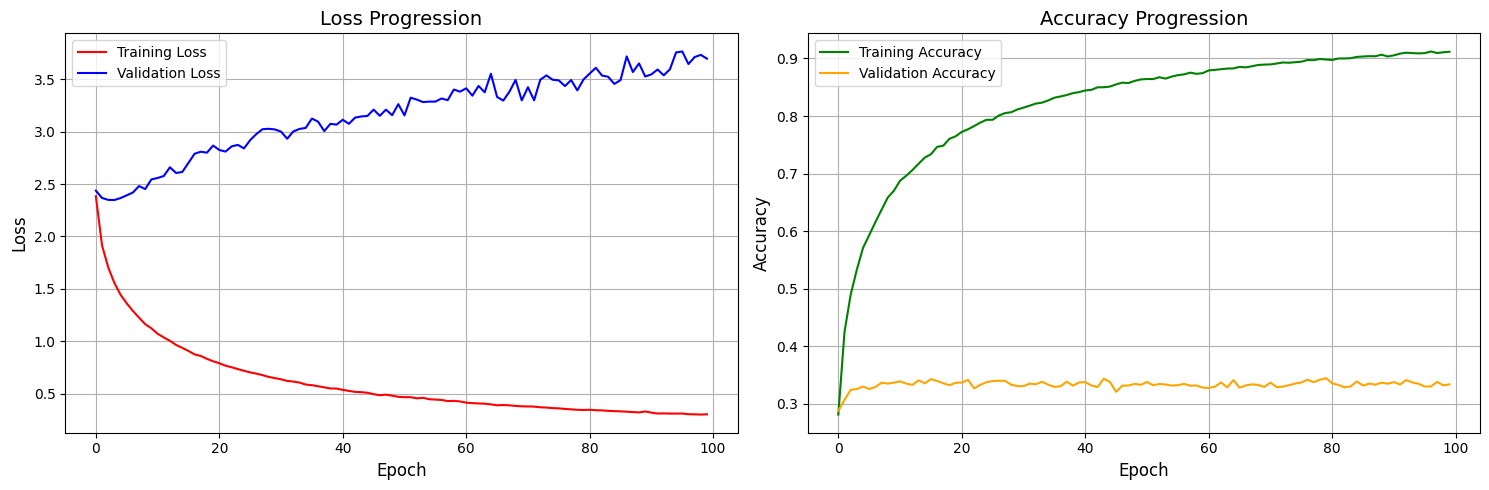

In [314]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [315]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - accuracy: 0.9771 - loss: 0.0936
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.3362 - loss: 3.7113


In [316]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.31      0.46      0.37       793
           1       0.39      0.56      0.46      1294
           2       0.35      0.34      0.34       617
           3       0.47      0.59      0.52       984
           4       0.08      0.09      0.08       229
           5       0.06      0.04      0.05       303
           6       0.21      0.15      0.18       275
           7       0.53      0.42      0.47       698
           8       0.16      0.56      0.24       176
           9       0.15      0.39      0.22       227
          10       0.22      0.21      0.22       455
          11       0.29      0.02      0.04      1660
          12       0.48      0.32      0.39      1261
          13       0.50      0.46      0.48       502
          14       0.16      0.17      0.16       156
          15       0.23      0.39      0.29       798
          16       0.50      0.41      0.45   

### With Mel Spectrogram and MFCCs

In [317]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc']), axis=1)
training_features.shape

(42578, 148)

In [318]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc']), axis=1)
validation_features.shape

(13083, 148)

In [319]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1840 - loss: 2.7073 - val_accuracy: 0.2721 - val_loss: 2.5178
Epoch 2/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3911 - loss: 2.0069 - val_accuracy: 0.2921 - val_loss: 2.4244
Epoch 3/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4697 - loss: 1.7643 - val_accuracy: 0.3088 - val_loss: 2.4429
Epoch 4/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5210 - loss: 1.5928 - val_accuracy: 0.3118 - val_loss: 2.4320
Epoch 5/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5518 - loss: 1.4996 - val_accuracy: 0.3054 - val_loss: 2.4725
Epoch 6/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5883 - loss: 1.3915 - val_accuracy: 0.3127 - val_loss: 2.4928
Epoch 7/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6045 - loss: 1.3335 - val_accuracy: 0.3129 - val_loss: 2.5231
Epoch 8/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6245 - loss: 1

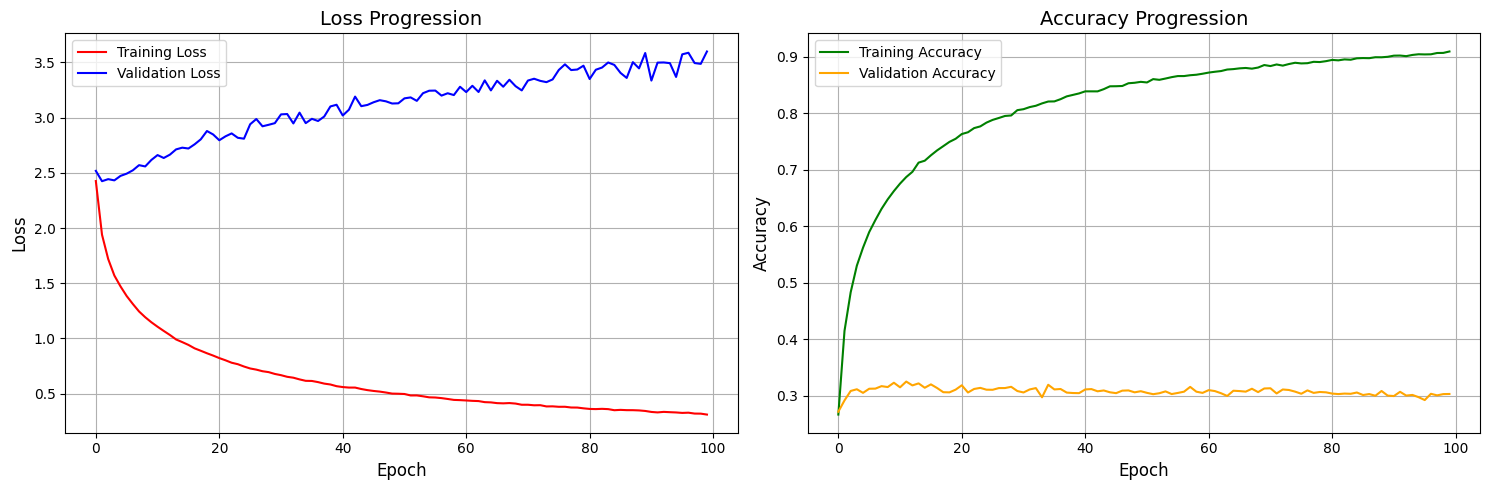

In [320]:
visualize(history, 'mfcc_melspectrogram')

In [321]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.9752 - loss: 0.1003
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3015 - loss: 3.6322


In [322]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.29      0.50      0.37       793
           1       0.43      0.59      0.50      1294
           2       0.36      0.26      0.30       617
           3       0.48      0.61      0.54       984
           4       0.13      0.12      0.12       229
           5       0.08      0.06      0.07       303
           6       0.10      0.08      0.09       275
           7       0.41      0.36      0.38       698
           8       0.13      0.56      0.21       176
           9       0.11      0.37      0.17       227
          10       0.32      0.33      0.32       455
          11       0.18      0.01      0.02      1660
          12       0.30      0.28      0.29      1261
          13       0.36      0.25      0.30       502
          14       0.09      0.19      0.12       156
          15       0.26      0.37      0.31       798
          16       0.29      0.16      0.21   

### With Mel Spectrogram

In [323]:
training_features = train_features['melspectrogram']
training_features.shape

(42578, 128)

In [324]:
validation_features = val_features['melspectrogram']
validation_features.shape

(13083, 128)

In [325]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1782 - loss: 2.7042 - val_accuracy: 0.2717 - val_loss: 2.5302
Epoch 2/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3801 - loss: 2.0450 - val_accuracy: 0.2997 - val_loss: 2.4756
Epoch 3/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4544 - loss: 1.8087 - val_accuracy: 0.3073 - val_loss: 2.4840
Epoch 4/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4998 - loss: 1.6651 - val_accuracy: 0.3120 - val_loss: 2.5195
Epoch 5/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5339 - loss: 1.5596 - val_accuracy: 0.3159 - val_loss: 2.4998
Epoch 6/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5560 - loss: 1.4754 - val_accuracy: 0.3215 - val_loss: 2.5274
Epoch 7/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5802 - loss: 1.4013 - val_accuracy: 0.3145 - val_loss: 2.5429
Epoch 8/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5936 - loss: 1

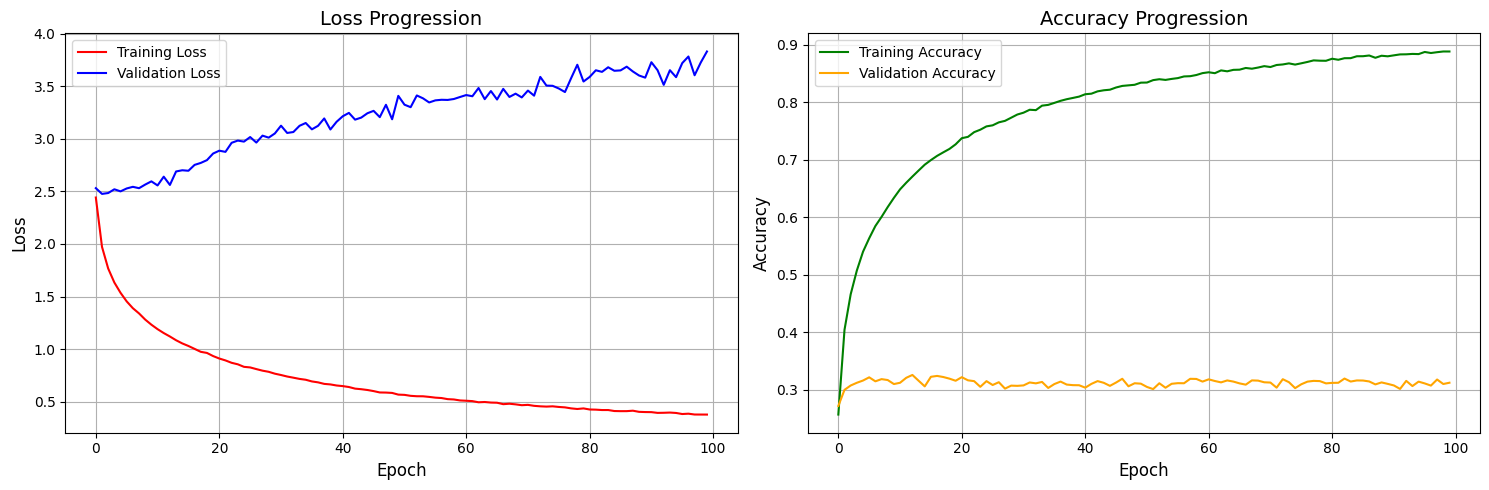

In [326]:
visualize(history, 'melspectrogram')

In [327]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.9667 - loss: 0.1337
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.3146 - loss: 3.8458


In [328]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.28      0.41      0.33       793
           1       0.39      0.58      0.47      1294
           2       0.36      0.33      0.35       617
           3       0.39      0.62      0.48       984
           4       0.07      0.07      0.07       229
           5       0.01      0.00      0.00       303
           6       0.02      0.01      0.01       275
           7       0.43      0.43      0.43       698
           8       0.13      0.48      0.20       176
           9       0.17      0.37      0.23       227
          10       0.22      0.18      0.20       455
          11       0.11      0.01      0.02      1660
          12       0.38      0.33      0.35      1261
          13       0.45      0.37      0.41       502
          14       0.14      0.28      0.19       156
          15       0.22      0.33      0.27       798
          16       0.47      0.37      0.41   

## Review all the results

In [329]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.988,0.359
4,melspectrogram,0.967,0.312
1,melspectrogram_chroma,0.971,0.320
2,melspectrogram_chroma_mfcc,0.978,0.334
3,mfcc_melspectrogram,0.976,0.303


In [330]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.344      0.808
4              melspectrogram     0.288      0.765
1       melspectrogram_chroma     0.296      0.777
2  melspectrogram_chroma_mfcc     0.317      0.787
3         mfcc_melspectrogram     0.283      0.788
